In [1]:
#Imports

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import confusion_matrix


In [2]:
def create_net(num_symbols):
    
    input_layer = layers.Input(shape=img_shape) 
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    out = [Dense(num_symbols, name='digit%d' % i, activation='softmax')(x) for i in range(5)]
    model = Model(inputs=input_layer, outputs=out)

    # initiate Adam optimizer
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()    
    
    return model

# Leitura dos dados e treinamento em lote

In [3]:
def read_dataset_batch(symbols, batch_files, captcha_dir = 'images/dataset'):
    
    num_symbols = len(symbols)
    n_samples = len(batch_files)
    #X = np.zeros((n_samples, 50, 200, 1))
    #X = np.zeros((n_samples, 60, 160, 1))
    X = np.zeros((n_samples, 30, 80, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i in range(n_samples):
        
        pic = batch_files[i];
        img = cv2.imread(os.path.join(captcha_dir, pic), cv2.IMREAD_GRAYSCALE)
        #img = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        #print(captcha_dir);
        pic_target = pic[:-4] # retira o .png
        #print(pic_target);
        #print(img);
        # Se nome do arquivo da imagem tem até 5 caracteres
        if len(pic_target) < 6:
            
            # Coloca o valor dos pixels entre 0 e 1
            img = img / 255.
            #print(img.shape)
            img = cv2.resize(img, (int(160/2), int(60/2)), interpolation=cv2.INTER_AREA)
            #print(img.shape)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            #img = np.reshape(img, (30, 80, 1))
            # cada captcha possui 5 caracteres
            targs = np.zeros((5, num_symbols))
            
            # Seta a sequência de letras alvo
            # O Alvo será uma matriz de todos símbolos pelas 5 posições presentes no captcha.
            # Se aquela posição corresponde aquele símbolo o valor da célula será 1, e 0 caso contrário.
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
                
            X[i] = img
            y[:, i] = targs
            
            if(i%1000 == 0):
                print(str(i) + " imagens read");

    return X, y

In [4]:
def read_name_files(files_dir = 'images/dataset'):

    folders = []

    # r=root, d=directories, f = files
    for r, d, f in os.walk(files_dir):
        # Nada
        s = "nada";
    return f

In [5]:
files = read_name_files()
print(len(files))

1000


In [6]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [7]:


def concat_history(history):
    
    global digit_acc, val_digit_acc, loss, val_loss
    
    digit_acc_now = [history.history['digit%d_accuracy' % i] for i in range(5)];
    val_digit_acc_now = [history.history['val_digit%d_accuracy' % i] for i in range(5)];
    loss_now = history.history['loss'];
    val_loss_now = history.history['val_loss'];    
    
    for i in range(5):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)

In [8]:
symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
#img_shape = (60, 160, 1)
img_shape = (80, 30, 1)
net = create_net(len(symbols))

# Estatísticas
digit_acc = [[] for _ in range(5)]
val_digit_acc = [[] for _ in range(5)]
loss = []
val_loss = []

i = 1;
for batch_files in batch(files, 100):    
    X_train, y_train = read_dataset_batch(symbols, batch_files)
    #print(X_train.shape())
    print("Inicio Treino #", str(i));
    i = i + 1
    history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=5, validation_split=0.2, batch_size=10)
    concat_history(history);

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 30, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 30, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 15, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 15, 48)   38448       max_pooling2d[0][0]              
______________________________________________________________________________________________

Epoch 2/5
8/8 [==============================] - 0s 57ms/step - loss: 0.4140 - digit0_loss: 0.0828 - digit1_loss: 0.0827 - digit2_loss: 0.0826 - digit3_loss: 0.0833 - digit4_loss: 0.0827 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0000e+00 - digit2_accuracy: 0.0125 - digit3_accuracy: 0.0125 - digit4_accuracy: 0.0125 - val_loss: 0.4139 - val_digit0_loss: 0.0812 - val_digit1_loss: 0.0823 - val_digit2_loss: 0.0841 - val_digit3_loss: 0.0814 - val_digit4_loss: 0.0848 - val_digit0_accuracy: 0.1000 - val_digit1_accuracy: 0.0000e+00 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0500 - val_digit4_accuracy: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 0s 48ms/step - loss: 0.4125 - digit0_loss: 0.0829 - digit1_loss: 0.0828 - digit2_loss: 0.0817 - digit3_loss: 0.0824 - digit4_loss: 0.0827 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0375 - digit2_accuracy: 0.0375 - digit3_accuracy: 0.0250 - digit4_accuracy: 0.0125 - val_loss: 0.4144 - val_digit0_loss: 0.0813 - val_digi

Epoch 5/5
8/8 [==============================] - 0s 49ms/step - loss: 0.4126 - digit0_loss: 0.0827 - digit1_loss: 0.0826 - digit2_loss: 0.0826 - digit3_loss: 0.0823 - digit4_loss: 0.0825 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0000e+00 - digit2_accuracy: 0.0250 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0250 - val_loss: 0.4125 - val_digit0_loss: 0.0828 - val_digit1_loss: 0.0821 - val_digit2_loss: 0.0825 - val_digit3_loss: 0.0826 - val_digit4_loss: 0.0825 - val_digit0_accuracy: 0.0000e+00 - val_digit1_accuracy: 0.0000e+00 - val_digit2_accuracy: 0.0500 - val_digit3_accuracy: 0.0000e+00 - val_digit4_accuracy: 0.0000e+00
0 imagens read
Inicio Treino # 5
Epoch 1/5
8/8 [==============================] - 0s 49ms/step - loss: 0.4135 - digit0_loss: 0.0826 - digit1_loss: 0.0829 - digit2_loss: 0.0826 - digit3_loss: 0.0827 - digit4_loss: 0.0827 - digit0_accuracy: 0.0000e+00 - digit1_accuracy: 0.0250 - digit2_accuracy: 0.0125 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0250 - 

Epoch 3/5
8/8 [==============================] - 0s 46ms/step - loss: 0.4129 - digit0_loss: 0.0825 - digit1_loss: 0.0826 - digit2_loss: 0.0826 - digit3_loss: 0.0826 - digit4_loss: 0.0826 - digit0_accuracy: 0.0375 - digit1_accuracy: 0.0000e+00 - digit2_accuracy: 0.0000e+00 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0000e+00 - val_loss: 0.4130 - val_digit0_loss: 0.0826 - val_digit1_loss: 0.0827 - val_digit2_loss: 0.0827 - val_digit3_loss: 0.0824 - val_digit4_loss: 0.0826 - val_digit0_accuracy: 0.0500 - val_digit1_accuracy: 0.0000e+00 - val_digit2_accuracy: 0.0000e+00 - val_digit3_accuracy: 0.0500 - val_digit4_accuracy: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 0s 47ms/step - loss: 0.4127 - digit0_loss: 0.0825 - digit1_loss: 0.0825 - digit2_loss: 0.0826 - digit3_loss: 0.0826 - digit4_loss: 0.0826 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0250 - digit2_accuracy: 0.0250 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0125 - val_loss: 0.4130 - val_digit0_los

0 imagens read
Inicio Treino # 10
Epoch 1/5
8/8 [==============================] - 0s 60ms/step - loss: 0.4131 - digit0_loss: 0.0827 - digit1_loss: 0.0827 - digit2_loss: 0.0826 - digit3_loss: 0.0826 - digit4_loss: 0.0825 - digit0_accuracy: 0.0250 - digit1_accuracy: 0.0000e+00 - digit2_accuracy: 0.0250 - digit3_accuracy: 0.0125 - digit4_accuracy: 0.0125 - val_loss: 0.4132 - val_digit0_loss: 0.0825 - val_digit1_loss: 0.0827 - val_digit2_loss: 0.0827 - val_digit3_loss: 0.0826 - val_digit4_loss: 0.0826 - val_digit0_accuracy: 0.0000e+00 - val_digit1_accuracy: 0.0000e+00 - val_digit2_accuracy: 0.0000e+00 - val_digit3_accuracy: 0.0000e+00 - val_digit4_accuracy: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 0s 61ms/step - loss: 0.4131 - digit0_loss: 0.0827 - digit1_loss: 0.0826 - digit2_loss: 0.0826 - digit3_loss: 0.0827 - digit4_loss: 0.0825 - digit0_accuracy: 0.0500 - digit1_accuracy: 0.0250 - digit2_accuracy: 0.0000e+00 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0000e+

In [9]:
def predict(img, n_symbols):
    
    #img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, n_symbols))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

In [10]:
def concat_plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    
    print("Params:")
    print(val_loss_now)
    
    global digit_acc, val_digit_acc, loss, val_loss
    for i in range(5):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    
    for i in range(5):
        plt.plot(digit_acc[i], label='digit%d_accuracy' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_accuracy' % i)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [11]:
def plot_diagram():
    
    
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(5):
        plt.plot(digit_acc[i], label='digit%d_accuracy' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_accuracy' % i)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

{'loss': [0.4130988121032715, 0.41309064626693726, 0.41295862197875977, 0.4129318594932556, 0.41291141510009766], 'digit0_loss': [0.08268135040998459, 0.08267679810523987, 0.08264221251010895, 0.08265408873558044, 0.0826336145401001], 'digit1_loss': [0.08265448361635208, 0.08259781450033188, 0.08260199427604675, 0.08258815109729767, 0.08258325606584549], 'digit2_loss': [0.08261886239051819, 0.08261577785015106, 0.08256956934928894, 0.0825830027461052, 0.08257738500833511], 'digit3_loss': [0.08264143764972687, 0.08266274631023407, 0.08260919898748398, 0.08260289579629898, 0.08261527866125107], 'digit4_loss': [0.08250268548727036, 0.08253750950098038, 0.08253560960292816, 0.08250369131565094, 0.08250187337398529], 'digit0_accuracy': [0.02500000037252903, 0.05000000074505806, 0.02500000037252903, 0.02500000037252903, 0.05000000074505806], 'digit1_accuracy': [0.0, 0.02500000037252903, 0.0, 0.012500000186264515, 0.0], 'digit2_accuracy': [0.02500000037252903, 0.0, 0.02500000037252903, 0.0125

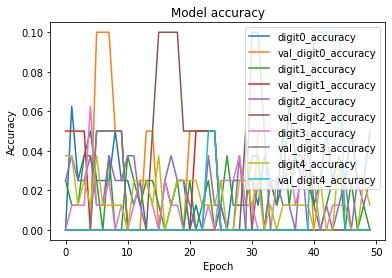

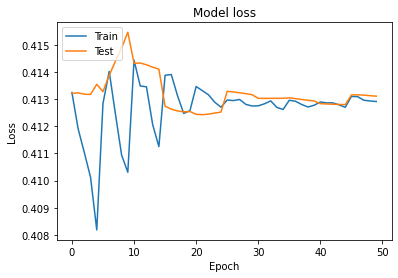

In [12]:


print(history.history)
plot_diagram()

#    plot_diagram(
#        [history.history['digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['digit%d_loss' % i] for i in range(5)],
#        [history.history['val_digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['val_digit%d_loss' % i] for i in range(5)],
#        history.history['loss'],
#        history.history['val_loss'],
#    )


In [13]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

<ipython-input-13-c6ab7055161c>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


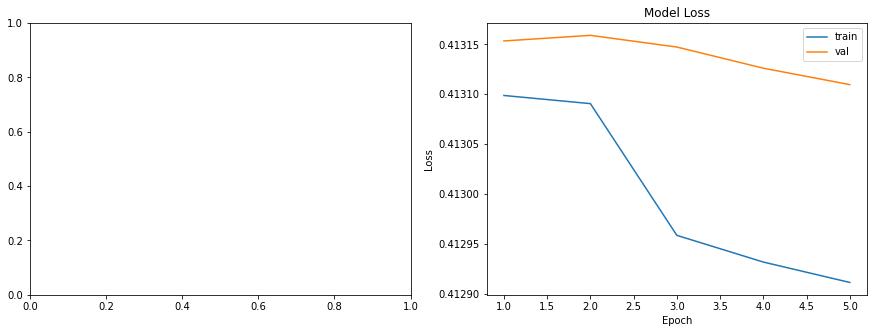

In [14]:
plot_model_history(history)

# Avaliar Dataset e Teste

In [19]:
# Leitura da pasta teste
n_dir = 'images/dataset_test';
files = read_name_files(files_dir = n_dir)
X_test, y_test = read_dataset_batch(symbols, files, captcha_dir = n_dir)
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


0 imagens read
1/1 [==============================] - 0s 861us/step - loss: 0.4129 - digit0_loss: 0.0826 - digit1_loss: 0.0826 - digit2_loss: 0.0826 - digit3_loss: 0.0826 - digit4_loss: 0.0825 - digit0_accuracy: 0.0000e+00 - digit1_accuracy: 0.0000e+00 - digit2_accuracy: 0.0000e+00 - digit3_accuracy: 0.0000e+00 - digit4_accuracy: 0.0000e+00


[0.41294237971305847,
 0.08260376751422882,
 0.08263608068227768,
 0.08259007334709167,
 0.08256923407316208,
 0.08254322409629822,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [75]:
# 7i4iB
def accuracy(x, y, model):
    
    y_d1 = np.argmax(y[0], axis=1);
    y_d2 = np.argmax(y[1], axis=1);
    y_d3 = np.argmax(y[2], axis=1);
    y_d4 = np.argmax(y[3], axis=1);
    y_d5 = np.argmax(y[4], axis=1);
    
    d1_num_correct = 0
    d2_num_correct = 0
    d3_num_correct = 0
    d4_num_correct = 0
    d5_num_correct = 0
    
    for i in range(x.shape[0]):
        capt, prop = predict(x[i], len(symbols))
        d1_num_correct = d1_num_correct + np.sum(capt[0] == symbols[y_d1[i]])
        d2_num_correct = d2_num_correct + np.sum(capt[1] == symbols[y_d2[i]])
        d3_num_correct = d3_num_correct + np.sum(capt[2] == symbols[y_d3[i]])
        d4_num_correct = d4_num_correct + np.sum(capt[3] == symbols[y_d4[i]])
        d5_num_correct = d5_num_correct + np.sum(capt[4] == symbols[y_d5[i]])
        
    
    num_samples = x.shape[0];
    num_caracteres = len(capt)*num_samples;
    num_correct = d1_num_correct + d2_num_correct + d3_num_correct + d4_num_correct + d5_num_correct
    
    d1_accuracy = float(d1_num_correct)/num_samples
    d2_accuracy = float(d2_num_correct)/num_samples
    d3_accuracy = float(d3_num_correct)/num_samples
    d4_accuracy = float(d4_num_correct)/num_samples
    d5_accuracy = float(d5_num_correct)/num_samples
    accuracy = float(num_correct)/num_caracteres
    
    return accuracy, d1_accuracy, d2_accuracy, d3_accuracy, d4_accuracy, d5_accuracy

In [76]:
#X_test = data_valid
#y_test = data_valid_target
#, y_test[1], y_test[2], y_test[3], y_test[4]
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%accuracy(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net))

Accuracy on test data is: 0.00, acc_d1= 0.00, acc_d2= 0.00, acc_d3= 0.00, acc_d4= 0.00, acc_d5= 0.00


--- Amostra #1 ---


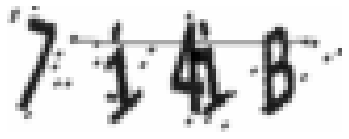

Predict: iKnJa


--- Amostra #1 ---


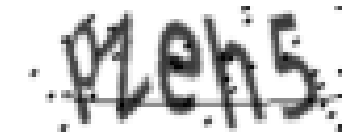

Predict: iK6Ja


--- Amostra #1 ---


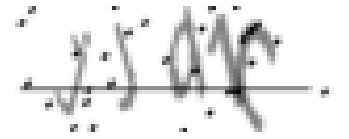

Predict: iKnGa




In [31]:
j = 1
for i in (0, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_test[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


--- Amostra #1 ---


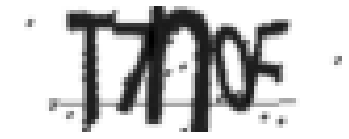

Predict: iKnua


--- Amostra #1 ---


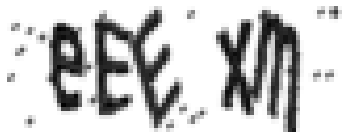

Predict: iKjqa


--- Amostra #1 ---


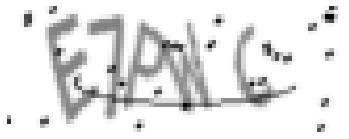

Predict: iK6qa




In [26]:
j = 1
for i in (1, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_train[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
